# Setup

In [1]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import optuna
import numpy as np
from sklearn.neural_network import MLPClassifier
import os, sys
CURRENT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(CURRENT_DIR+"/metrics.py"))

from metrics import CalcMetrics

get_metric = CalcMetrics()

/home/ronald/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv("../datasets/processed/train.csv")
val_df = pd.read_csv("../datasets/processed/validation.csv")
test_df = pd.read_csv("../datasets/processed/test.csv")

In [4]:
features = train_df.columns.drop('satisfaction')
target = 'satisfaction'

In [5]:
X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Modelo base

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(10,), random_state=42)

In [9]:
mlp.fit(X_train, y_train)

In [25]:
y_pred = mlp.predict_proba(X_test)[:,1]

In [26]:
y_pred

array([9.98124044e-01, 9.99999953e-01, 6.75389775e-04, ...,
       4.60711215e-06, 9.98828438e-01, 9.70341042e-06])

In [27]:
get_metric.ks(y_pred, y_test)

np.float64(0.8934214168540269)

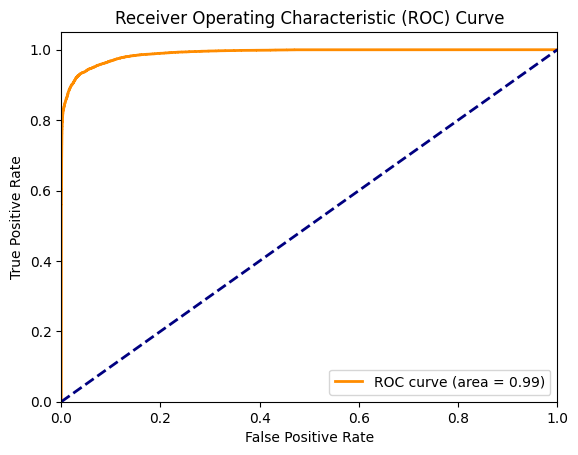

In [28]:
get_metric.auc(y_pred, y_test)

# Teste inicial com o Optuna

In [9]:
def objective(trial):
    epochs = trial.suggest_int('epochs', 10, 25)
    n_layers = trial.suggest_int('n_layers', 1, 3)  # Number of layers
    hidden_layer_sizes = tuple(trial.suggest_int(f'n_units_l{i}', 10, 200) for i in range(n_layers))  # Start small, increase as needed
    learning_rate_init = trial.suggest_float('learning_rate_init', 0.0001, 0.1, log=True)
    activation = trial.suggest_categorical('activation', ['logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 0.00001, 0.01, log=True)  # L2 regularization
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0, 0.5)  # Dropout rate

    # Initialize MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        activation=activation,
        solver=solver,
        alpha=alpha,
        warm_start=True,  # So we can call partial_fit
        max_iter=1,       # So we train for one iteration at a time
        random_state=42
    )

    # Initialize variables for early stopping
    best_val_score = -float('inf')
    epochs_no_improve = 0
    patience = 10
    max_epochs = 500
    improvement_threshold = 1e-2  # Minimal improvement threshold


    for epoch in range(epochs):
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))  # Perform one epoch of training

        # Validate the model
        val_pred = mlp.predict_proba(X_val)[:,1]
        val_score = get_metric.ks(val_pred, y_val)
        
        # Check if validation score improved
        if val_score - best_val_score > improvement_threshold:
            best_val_score = val_score
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Check early stopping condition
        if epochs_no_improve >= patience:
            break
    
    test_pred = mlp.predict_proba(X_test)[:,1]
    test_score = get_metric.ks(test_pred, y_test)
    return test_score


In [10]:
# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-07-28 14:00:35,297] A new study created in memory with name: no-name-646f1de1-3a43-4f76-9b04-d6a49d72c5a3
[I 2024-07-28 14:01:07,820] Trial 0 finished with value: 0.8861344043477202 and parameters: {'epochs': 16, 'n_layers': 3, 'n_units_l0': 119, 'n_units_l1': 130, 'n_units_l2': 47, 'learning_rate_init': 0.00020584716709905418, 'activation': 'relu', 'solver': 'adam', 'alpha': 3.0813836801526114e-05}. Best is trial 0 with value: 0.8861344043477202.
[I 2024-07-28 14:02:10,844] Trial 1 finished with value: 0.5930159892782058 and parameters: {'epochs': 23, 'n_layers': 3, 'n_units_l0': 136, 'n_units_l1': 119, 'n_units_l2': 111, 'learning_rate_init': 0.0006151562462442542, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0003723518940807477}. Best is trial 0 with value: 0.8861344043477202.
[I 2024-07-28 14:02:21,166] Trial 2 finished with value: 0.9103448917890444 and parameters: {'epochs': 17, 'n_layers': 2, 'n_units_l0': 71, 'n_units_l1': 64, 'learning_rate_init': 0.0039467046

In [11]:
# Best hyperparameters
print(f'Best Hyperparameters: {study.best_params}')
print(f'Best value: {study.best_value}')

Best Hyperparameters: {'epochs': 12, 'n_layers': 3, 'n_units_l0': 192, 'n_units_l1': 71, 'n_units_l2': 123, 'learning_rate_init': 0.08177715807672514, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0034841450783612967}
Best value: 0.9130751369577201


In [38]:
best_mlp = MLPClassifier(
    hidden_layer_sizes=tuple(best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])),
    learning_rate_init=best_params['learning_rate_init'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    alpha=best_params['alpha'],
    max_iter=200,
    random_state=42
)

In [39]:
best_mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.0017360992714110025, hidden_layer_sizes=(67, 20),
              learning_rate_init=0.010047325174366043, random_state=42)

In [45]:
val_pred = best_mlp.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
print(f'Validation Accuracy: {val_accuracy*100:.3f}')

Validation Accuracy: 95.881


In [46]:
test_pred = best_mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)
print(f'Test Accuracy: {test_accuracy*100:.3f}')

Test Accuracy: 96.139
